# Implementation of Softmax Regression from Scratch

Just as we implemented linear regression from scratch, we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know the gory details of how to implement it from scratch. As
with linear regression, after doing things by hand we will breeze through an implementation in PyTorch for
comparison. To begin, let’s import our packages

In [1]:
# import packages
import torch
import torchvision
import numpy as np
import d2l
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython import display

We will work with the Fashion-MNIST dataset just introduced, cuing up an iterator with batch size 256.

In [2]:
def load_data_fashion_mnist(batch_size, resize=None, num_workers=0):
    tranform_list = []
    if resize:
        tranform_list.append(torchvision.transforms.Resize(resize))
    tranform_list.append(transforms.ToTensor())
    transform = transforms.Compose(tranform_list)
    mnist_train = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                 download=True,
                                 train=True,
                                 transform=transform)

    mnist_test = datasets.FashionMNIST('~/datasets/F_MNIST/',
                                     download=True,
                                     train=False,
                                    transform=transform)
    
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, 
                                          shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, 
                                              shuffle=False)
    return train_iter, test_iter

In [3]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## Initialize Model Parameters

Just as in linear regression, we represent each example as a vector. Since each example is a 28 x 28 image,
we can flatten each example, treating them as 784 dimensional vectors. In the future, we’ll talk about more
sophisticated strategies for exploiting the spatial structure in images, but for now we treat each pixel location
as just another feature.

Recall that in softmax regression, we have as many outputs as there are categories. Because our dataset has
10 categories, our network will have an output dimension of 10. Consequently, our weights will constitute a
784 x 10 matrix and the biases will constitute a 1 x 10 vector. As with linear regression, we will initialize
our weights W with Gaussian noise and our biases to take the initial value 0.

In [5]:
num_inputs = 784
num_outputs = 10

W = 0.01**(0.5)*torch.randn(size=(num_inputs, num_outputs))
b = torch.zeros((num_outputs,))

Recall that we need to attach gradients to the model parameters. More literally, we are allocating memory
for future gradients to be stored and notifiying PyTorch that we want gradients to be calculated with respect
to these parameters in the first place.

In [7]:
W.requires_grad = True
b.requires_grad = True

## The Softmax

Before implementing the softmax regression model, let’s briefly review how operators such as sum work along
specific dimensions in a tensor. Given a matrix X we can sum over all elements (default) or only over
elements in the same column (axis=0) or the same row (axis=1). 

Note that if X is an array with shape (2, 3) and we sum over the columns (X.sum(axis=0), the result will be a (1D) vector with shape (3,). If we
want to keep the number of axes in the original array (resulting in a 2D array with shape (1,3)), rather
than collapsing out the dimension that we summed over we can specify keepdims=True when invoking sum.

In [8]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])

In [9]:
X

tensor([[1, 2, 3],
        [4, 5, 6]])

In [10]:
# illustrate using dim=0
X.sum(dim=0)

tensor([5, 7, 9])

In [11]:
# illustrate using dim=1
X.sum(dim=1)

tensor([ 6, 15])

In [16]:
# illustrate using dim=1 and keepdims
X.sum(dim=1, keepdims=True)

tensor([[ 6],
        [15]])

We are now ready to implement the softmax function. Recall that softmax consists of two steps: First, we
exponentiate each term (using exp). Then, we sum over each row (we have one row per example in the
batch) to get the normalization constants for each example. Finally, we divide each row by its normalization
constant, ensuring that the result sums to 1. Before looking at the code, let’s recall what this looks expressed
as an equation: $$\mbox{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}$$.

In [26]:
def softmax(X):
    X_exp = X.exp()
    normalization_term = X_exp.sum(dim=1, keepdims=True)
    return X_exp/normalization_term # The broadcast mechanism is applied here

In [28]:
# illustrate using 2 x 3 matrix and show columns sum up to 1
X = torch.randn(size=(2, 3))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.5311, 0.1780, 0.2909],
         [0.2665, 0.4629, 0.2706]]), tensor([1., 1.]))

## The Model

Now that we have defined the softmax operation, we can implement the softmax regression model. The
below code defines the forward pass through the network. Note that we flatten each original image in the
batch into a vector with length num_inputs with the reshape function before passing the data through our
model.

In [29]:
def net(X):
    O = torch.matmul(X.reshape((-1, num_inputs)), W) + b
    return softmax(O)

In [33]:
# illustrate net with 32, 28, 28 random vector
X = torch.randn(size=(32, 28, 28))
y_hat = net(X)

In [34]:
y_hat.shape

torch.Size([32, 10])

In [35]:
for X, y in train_iter:
    break

In [36]:
X.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [37]:
y_hat = net(X)
y_hat.shape

torch.Size([256, 10])

In [38]:
y[:10]

tensor([0, 6, 5, 4, 9, 3, 3, 8, 2, 3])

In [42]:
y_hat[:10, :5]

tensor([[1.2139e-01, 3.4000e-01, 1.6197e-01, 3.4972e-02, 5.0416e-02],
        [6.3273e-02, 2.1201e-01, 3.7534e-01, 5.9034e-03, 3.4690e-02],
        [4.4390e-02, 1.6499e-01, 1.3135e-01, 3.8085e-02, 3.1692e-02],
        [5.4637e-02, 6.3848e-01, 1.3256e-01, 7.6910e-03, 9.2339e-02],
        [7.4171e-03, 7.5034e-02, 6.7372e-02, 2.5162e-02, 1.0211e-02],
        [7.3446e-02, 2.3283e-01, 1.8483e-01, 2.8498e-02, 8.1105e-02],
        [1.4190e-01, 1.6233e-01, 1.7315e-01, 7.6300e-02, 1.9175e-01],
        [6.6476e-03, 7.2563e-02, 8.0253e-01, 5.6737e-04, 1.8064e-02],
        [1.5011e-01, 3.8795e-01, 1.2912e-01, 8.8158e-03, 7.6395e-02],
        [4.0823e-02, 1.8897e-01, 9.6117e-02, 5.5470e-02, 4.6929e-02]],
       grad_fn=<SliceBackward>)

In [49]:
y_hat[:10, :5].argmax(dim=1)

tensor([1, 2, 1, 1, 1, 1, 4, 2, 1, 1])

In [46]:
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1214],
        [0.1314],
        [0.0930],
        [0.0923],
        [0.0039],
        [0.0285],
        [0.0763],
        [0.0274],
        [0.1291],
        [0.0555],
        [0.3496],
        [0.0210],
        [0.1813],
        [0.1046],
        [0.0060],
        [0.1084],
        [0.1004],
        [0.0640],
        [0.0493],
        [0.0934],
        [0.0195],
        [0.0215],
        [0.3308],
        [0.0035],
        [0.1553],
        [0.0428],
        [0.1871],
        [0.0490],
        [0.0716],
        [0.1009],
        [0.0927],
        [0.0526],
        [0.0018],
        [0.0090],
        [0.1312],
        [0.0016],
        [0.3312],
        [0.0341],
        [0.1683],
        [0.0058],
        [0.0704],
        [0.0471],
        [0.3992],
        [0.2264],
        [0.0550],
        [0.2661],
        [0.0115],
        [0.1566],
        [0.0606],
        [0.0046],
        [0.0014],
        [0.2084],
        [0.1688],
        [0.0136],
        [0.0104],
        [0

## The Loss Function

Next, we need to implement the cross-entropy loss function, introduced in the class. This may be the most
common loss function in all of deep learning because, at the moment, classification problems far outnumber
regression problems.

Recall that cross-entropy takes the negative log likelihood of the predicted probability assigned to the true
label $\log p(y|x)$.

In [47]:
def cross_entropy(y_hat, y):
    return torch.mean(-torch.log(y_hat.gather(1, y.view(-1, 1))))

## Classification Accuracy

Given the predicted probability distribution ``y_hat``, we typically choose the class with highest predicted
probability whenever we must output a hard prediction.

In [50]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).sum()

Here, we define ``Accumulator`` is a utility class to accumulate sum over multiple numbers.

In [51]:
class Accumulator(object):
    """Sum a list of numbers over time"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a+b for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

Now, we can evaluate the accuracy for model net on the data set (accessed via data_iter).

In [52]:
def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), len(y))
    return float(metric[0])/metric[1]

In [53]:
# illustrate evaluate_accuracy on our test_iter and net
evaluate_accuracy(net, test_iter)

0.1364

## Model Training

The training loop for softmax regression should look strikingly familiar to our implementation
of linear regression. Here we refactor the implementation to make it reusable. First,
we define a function to train for one data epoch. Note that updater is general function to update the model
parameters. 

Let's grab our sgd function we used in linear regression from scratch notebook.

In [54]:
def sgd(params, lr):
    for param in params:
        param.data -= lr*param.grad.data
        param.grad.data.zero_()

In [55]:
def train_epoch(net, train_iter, loss, updater):
    metric = Accumulator(3) # train_loss_sum, train_acc_sum, num_examples
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        # compute the gradients and update parameters
        l.backward()
        updater()
        l_sum = float(l)*len(y)
        metric.add(l_sum, float(accuracy(y_hat, y)), len(y))
    return metric[0]/metric[2], metric[1]/metric[2]

Before showing the implementation of the training function, we define a utility class that draw data in
animation. Again, it aims to simplify the codes in later chapters.

In [56]:
class Animator(object):
    def __init__(self, xlabel=None, ylabel=None, legend=[], xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(3.5, 2.5)):
        """Incrementally plot multiple lines."""
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes,]
        # use a lambda to capture arguments
        self.config_axes = lambda : d2l.set_axes(self.axes[0], xlabel, ylabel,
                                                 xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if not self.X: self.X = [[] for _ in range(n)]
        if not self.Y: self.Y = [[] for _ in range(n)]
        if not self.fmts: self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The training function then runs multiple epochs and visualize the training progress.

In [57]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    trains, test_accs = [], []
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], 
                        ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

Again, we use the mini-batch stochastic gradient descent to optimize the loss function of the model. Note
that the number of epochs (num_epochs), and learning rate (lr) are both adjustable hyper-parameters. By
changing their values, we may be able to increase the classification accuracy of the model. In practice we’ll
want to split our data three ways into training, validation, and test data, using the validation data to choose
the best values of our hyperparameters.

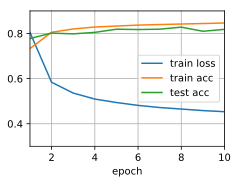

In [58]:
num_epochs = 10
lr = 0.1
updater = lambda: sgd([W, b], lr)

train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


## Prediction

Now that training is complete, our model is ready to classify some images. Given a series of images, we will
compare their actual labels (first line of text output) and the model predictions (second line of text output).

Let's grab our functions for visualization and Fashion-MNIST labels from the notebook ``image_classification_data_Fashion-MNIST``.

In [59]:
# taken from d2l but modified to fit to PyTorch
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.squeeze(0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
            
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boot']
    return [text_labels[int(i)] for i in labels]

In [60]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y.numpy())
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1).numpy())
    titles = [true+'\n'+ pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n,28,28)), 1, n, titles=titles[0:n])

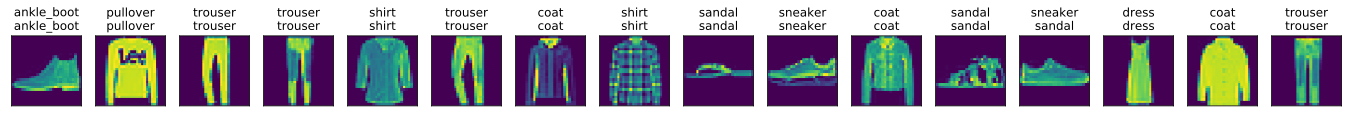

In [61]:
predict(net, test_iter, 16)

## Summary

With softmax regression, we can train models for multi-category classification. The training loop is very
similar to that in linear regression: retrieve and read data, define models and loss functions, then train
models using optimization algorithms. As you’ll soon find out, most common deep learning models have
similar training procedures.